<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [7]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [8]:
import re
import pandas as pd

# Leer el archivo txt línea por línea
with open('bible.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Remove newline characters and empty lines
cleaned_text_list = [line.replace('\n', '') for line in lines if line.strip()]

# Combine lines that belong to the same verse
combined_lines = []
current_line = ""

for line in cleaned_text_list:
    if line[0].isdigit() and ':' in line:
        if current_line:
            combined_lines.append(current_line)
        current_line = line
    else:
        current_line += " " + line

if current_line:
    combined_lines.append(current_line)

# Remove number:number pattern from each line
cleaned_combined_lines = [re.sub(r'^\d+:\d+\s', '', line) for line in combined_lines]

# Crear un DataFrame con las líneas de texto
df = pd.DataFrame(cleaned_combined_lines, columns=['text'])

# Export the cleaned combined lines to a new text file
with open('cleaned_combined_bible.txt', 'w', encoding='utf-8') as file:
    for line in cleaned_combined_lines:
        file.write(line + '\n')


print(df.head())
print("\nCantidad de documentos:", df.shape[0])

                                                text
0  In the beginning God created the heaven and th...
1  And the earth was without form, and void; and ...
2  And God said, Let there be light: and there wa...
3  And God saw the light, that it was good: and G...
4  And God called the light Day, and the darkness...

Cantidad de documentos: 334


In [9]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 334


### Elegir el tamaño del contexto

In [10]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [11]:
# cada verso lo guardamos en una lista
text = list(df['text'])
text

['In the beginning God created the heaven and the earth.',
 'And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.',
 'And God said, Let there be light: and there was light.',
 'And God saw the light, that it was good: and God divided the light from the darkness.',
 'And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day.',
 'And God said, Let there be a firmament in the midst of the waters, and let it divide the waters from the waters.',
 'And God made the firmament, and divided the waters which were under the firmament from the waters which were above the firmament: and it was so.',
 'And God called the firmament Heaven. And the evening and the morning were the second day.',
 'And God said, Let the waters under the heaven be gathered together unto one place, and let the dry land appear: and it was so.',
 'And God called the dry land Eart

In [12]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [13]:
text[0]

'In the beginning God created the heaven and the earth.'

In [14]:
segmented_sentences[0]

['in',
 'the',
 'beginning',
 'god',
 'created',
 'the',
 'heaven',
 'and',
 'the',
 'earth']

In [15]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([34., 41., 60., 59., 35., 27., 18., 20., 17.,  5.,  4.,  4.,  5.,
         1.,  1.,  2.,  0.,  0.,  0.,  1.]),
 array([  8.  ,  13.05,  18.1 ,  23.15,  28.2 ,  33.25,  38.3 ,  43.35,
         48.4 ,  53.45,  58.5 ,  63.55,  68.6 ,  73.65,  78.7 ,  83.75,
         88.8 ,  93.85,  98.9 , 103.95, 109.  ]),
 <BarContainer object of 20 artists>)

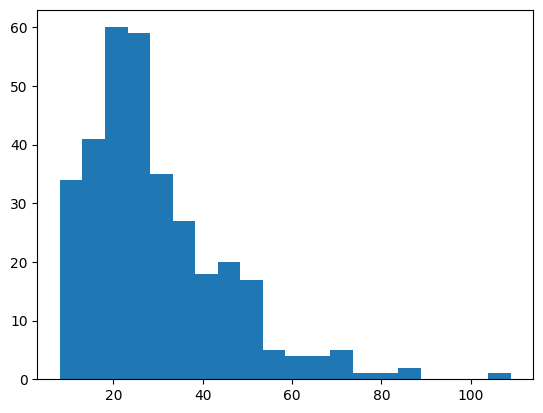

In [16]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [17]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 49


###  Tokenizar

In [18]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [19]:
tokenized_sentences[0]

[4, 2, 369, 11, 139, 2, 94, 1, 2, 12]

In [20]:
segmented_sentences[0]

['in',
 'the',
 'beginning',
 'god',
 'created',
 'the',
 'heaven',
 'and',
 'the',
 'earth']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [21]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [22]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [23]:
len(tok_sent)

668

In [24]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [25]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [26]:
train_seqs.shape

(26974, 50)

In [27]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [28]:
y.shape

(26974, 49)

In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'and',
 2: 'the',
 3: 'of',
 4: 'in',
 5: 'that',
 6: 'he',
 7: 'to',
 8: 'his',
 9: 'unto',
 10: 'was',
 11: 'god',
 12: 'earth',
 13: 'i',
 14: 'a',
 15: 'it',
 16: 'shall',
 17: 'be',
 18: 'said',
 19: 'thou',
 20: 'lord',
 21: 'is',
 22: 'all',
 23: 'him',
 24: 'every',
 25: 'after',
 26: 'thee',
 27: 'begat',
 28: 'were',
 29: 'years',
 30: 'thy',
 31: 'for',
 32: 'with',
 33: 'they',
 34: 'from',
 35: 'upon',
 36: 'abram',
 37: 'will',
 38: 'which',
 39: 'them',
 40: 'hundred',
 41: 'sons',
 42: 'not',
 43: 'man',
 44: 'noah',
 45: 'her',
 46: 'me',
 47: 'their',
 48: 'had',
 49: 'name',
 50: 'shalt',
 51: 'lived',
 52: 'land',
 53: 'my',
 54: 'waters',
 55: 'there',
 56: 'days',
 57: 'wife',
 58: 'day',
 59: 'went',
 60: 'an',
 61: 'she',
 62: 'forth',
 63: 'seed',
 64: 'have',
 65: 'ark',
 66: 'also',
 67: 'made',
 68: 'came',
 69: 'face',
 70: 'called',
 71: '5',
 72: 'into',
 73: 'when',
 74: 'out',
 75: 'flesh',
 76: 'as',
 77: 'covenant',
 78: 'king',
 79: 'two',
 80: '

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1160

In [31]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'and': 1, 'the': 2, 'of': 3, 'in': 4, 'that': 5, 'he': 6, 'to': 7, 'his': 8, 'unto': 9, 'was': 10, 'god': 11, 'earth': 12, 'i': 13, 'a': 14, 'it': 15, 'shall': 16, 'be': 17, 'said': 18, 'thou': 19, 'lord': 20, 'is': 21, 'all': 22, 'him': 23, 'every': 24, 'after': 25, 'thee': 26, 'begat': 27, 'were': 28, 'years': 29, 'thy': 30, 'for': 31, 'with': 32, 'they': 33, 'from': 34, 'upon': 35, 'abram': 36, 'will': 37, 'which': 38, 'them': 39, 'hundred': 40, 'sons': 41, 'not': 42, 'man': 43, 'noah': 44, 'her': 45, 'me': 46, 'their': 47, 'had': 48, 'name': 49, 'shalt': 50, 'lived': 51, 'land': 52, 'my': 53, 'waters': 54, 'there': 55, 'days': 56, 'wife': 57, 'day': 58, 'went': 59, 'an': 60, 'she': 61, 'forth': 62, 'seed': 63, 'have': 64, 'ark': 65, 'also': 66, 'made': 67, 'came': 68, 'face': 69, 'called': 70, '5': 71, 'into': 72, 'when': 73, 'out': 74, 'flesh': 75, 'as': 76, 'covenant': 77, 'king': 78, 'two': 79, 'make': 80, 'behold': 81, 'let': 82, 'one': 83, 'thing': 84, 'but': 85, 'this': 86, 

In [32]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'beginning': 3, 'heaven': 15, 'earth': 73, 'and': 318, 'in': 112, 'god': 82, 'the': 274, 'created': 7, 'without': 3, 'void': 1, 'face': 20, 'form': 1, 'deep': 5, 'moved': 2, 'waters': 25, 'was': 82, 'darkness': 5, 'of': 216, 'upon': 45, 'spirit': 2, 'be': 67, 'light': 6, 'let': 14, 'there': 27, 'said': 71, 'saw': 15, 'good': 15, 'divided': 7, 'that': 98, 'it': 70, 'from': 50, 'were': 52, 'evening': 7, 'called': 20, 'morning': 6, 'day': 25, 'night': 6, 'first': 6, 'he': 88, 'a': 67, 'divide': 3, 'firmament': 6, 'midst': 4, 'made': 22, 'under': 5, 'above': 5, 'which': 42, 'so': 16, 'second': 5, 'place': 4, 'together': 5, 'one': 18, 'land': 28, 'gathered': 2, 'appear': 1, 'unto': 90, 'dry': 4, 'gathering': 1, 'seas': 2, 'tree': 13, 'kind': 7, 'herb': 7, 'is': 60, 'fruit': 7, 'whose': 6, 'forth': 23, 'bring': 10, 'grass': 2, 'after': 47, 'yielding': 3, 'itself': 2, 'seed': 21, 'his': 78, 'brought': 10, 'third': 3, 'days': 28, 'seasons': 1, 'give': 10, 'for': 49,


### Definir el modelo

In [33]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

c:\Python310\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 50)       │        58,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 1161)     │       117,261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,111 (1.21 MB)

 Trainable params: 316,111 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [35]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 3.2617
 mean perplexity: 365.9671106212147 

Saved new model!
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - loss: 3.2591
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.3199
 mean perplexity: 368.8626590420081 

422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 114ms/step - loss: 2.3198
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.9951
 mean perplexity: 426.1750440221585 

422/422 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - loss: 1.9950
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.7378
 mean perplexity: 488.1482129254627 

422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 110ms/step - loss: 1.7377
Epoch 5/20
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.5183
 mean perplexity: 574.8179937299972 

422/422 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - loss: 1.5180
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.2898
 mean perplexity: 634.1796548148781 

Stopping training...
422/422 ━━━━━━━━━━━━━━━━━━

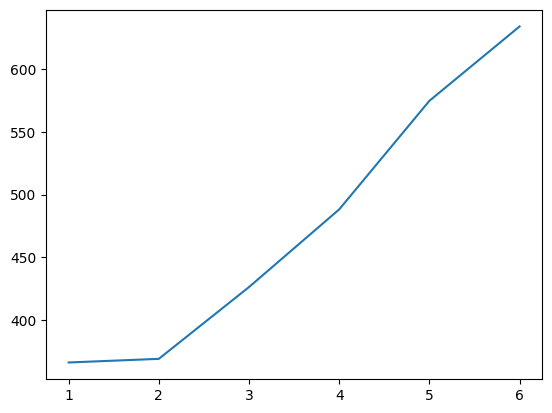

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [37]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra

In [38]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

C:\Users\marti\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [40]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [47]:
input_text='the lord'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


'the lord and and and and and and and and and and'

###  Beam search y muestreo aleatorio

In [42]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [43]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [44]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')

In [45]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 55)

In [46]:
# veamos las salidas
decode(salidas[0])

['when i myself in and said and and the sorrow']

In [83]:
# 1. Cargar y preparar el corpus
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout



with open('bible.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()


In [84]:
# Combinar líneas que pertenecen al mismo versículo
combined_lines = []
current_line = ""

for line in cleaned_text_list:
    if line[0].isdigit() and ':' in line:
        if current_line:
            combined_lines.append(current_line)
        current_line = line
    else:
        current_line += " " + line

if current_line:
    combined_lines.append(current_line)

# Eliminar el patrón número:número de cada línea
cleaned_combined_lines = [re.sub(r'^\d+:\d+\s', '', line) for line in combined_lines]

# Crear un corpus a partir de las líneas limpiadas
corpus = " ".join(cleaned_combined_lines)

corpus


" In the beginning God created the heaven and the earth. And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters. And God said, Let there be light: and there was light. And God saw the light, that it was good: and God divided the light from the darkness. And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day. And God said, Let there be a firmament in the midst of the waters, and let it divide the waters from the waters. And God made the firmament, and divided the waters which were under the firmament from the waters which were above the firmament: and it was so. And God called the firmament Heaven. And the evening and the morning were the second day. And God said, Let the waters under the heaven be gathered together unto one place, and let the dry land appear: and it was so. And God called the dry land Earth; and the gathering together of the

In [96]:
# 1. Separar el corpus en oraciones
sentences = corpus.split('.')

# 2. Tokenización y generación de secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = len(word_index) + 1

# 3. Crear secuencias de entrenamiento
sequences = []
for sentence in sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        seq = token_list[:i+1]
        sequences.append(seq)

# 4. Padding de las secuencias
#max_sequence_length = max(len(seq) for seq in sequences)
max_sequence_length = 30
sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

print('Max sequence length:', max_sequence_length)
print('Vocabulary size:', vocab_size)


Max sequence length: 30
Vocabulary size: 1161


In [106]:
X = sequences[:, :-1]
y = sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

# Dividir en conjunto de entrenamiento y validación
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Definir una función para construir modelos
def build_model(model_type, vocab_size, embedding_dim, max_sequence_length, hidden_units):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length-1),
        model_type(hidden_units, return_sequences=False),
        Dropout(0.2),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
    return model

# Callback para calcular la perplejidad
def perplexity(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(cross_entropy)
    return tf.reduce_mean(perplexity)

class PerplexityCallback(Callback):
    def __init__(self):
        self.perplexities = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        val_perplexity = perplexity(y_val, self.model.predict(X_val, verbose=0)).numpy()
        self.perplexities.append(val_perplexity)
        self.losses.append(logs['val_loss'])
        print(f'\nEpoch {epoch+1}: Validation Perplexity = {val_perplexity:.4f}')

In [107]:
# Entrenar y evaluar modelos
embedding_dim = 50
hidden_units = 128
model_types = {'SimpleRNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}
results = {}

for name, model_type in model_types.items():
    print(f'Entrenando modelo: {name}')
    model = build_model(model_type, vocab_size, embedding_dim, max_sequence_length, hidden_units)
    perplexity_callback = PerplexityCallback()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[perplexity_callback]
    )
    results[name] = {
        'model': model,
        'history': history,
        'perplexities': perplexity_callback.perplexities,
        'losses': perplexity_callback.losses
    }

Entrenando modelo: SimpleRNN
Epoch 1/20
235/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0834 - loss: 5.8301
Epoch 1: Validation Perplexity = 1560.1637
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0840 - loss: 5.8224 - val_accuracy: 0.0886 - val_loss: 5.7846
Epoch 2/20
236/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1564 - loss: 5.2830
Epoch 2: Validation Perplexity = 1338.2458
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1567 - loss: 5.2807 - val_accuracy: 0.1166 - val_loss: 5.6469
Epoch 3/20
237/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1906 - loss: 4.9179
Epoch 3: Validation Perplexity = 2400.6362
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1906 - loss: 4.9178 - val_accuracy: 0.1192 - val_loss: 5.6594
Epoch 4/20
237/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2137 - loss: 4.7324
Epoch 4: Validation Perplexity = 2230.2024
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2136 - loss: 4.7326 - val_accuracy: 0.1135 - val

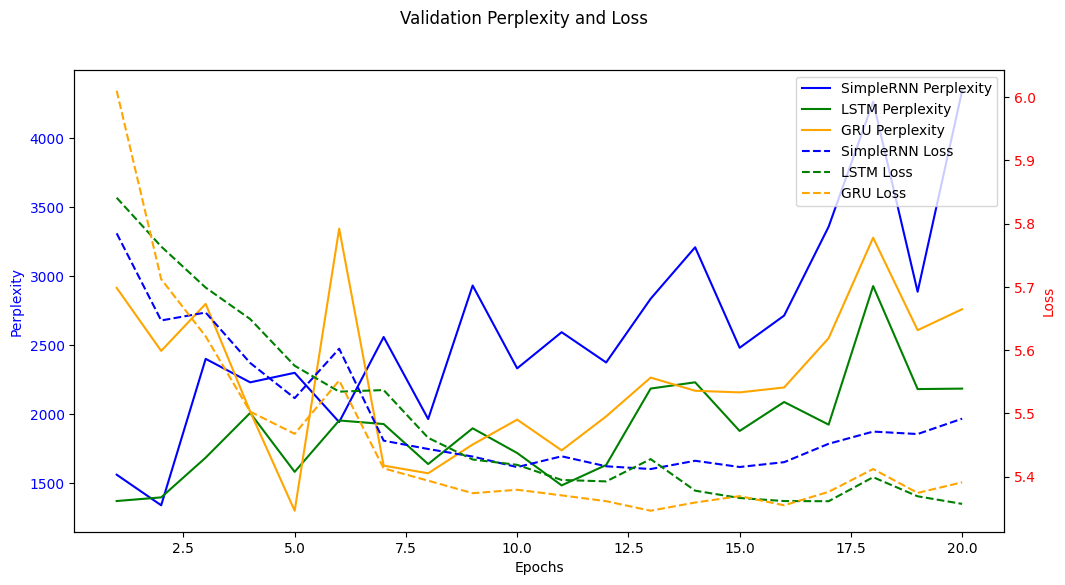

In [113]:
# Graficar perplejidad y pérdida
fig, ax1 = plt.subplots(figsize=(12, 6))

# Lista de colores para las gráficas
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

# Eje izquierdo para la perplejidad
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Perplexity', color='blue')
for i, (name, result) in enumerate(results.items()):
    epochs = range(1, len(result['perplexities']) + 1)
    ax1.plot(epochs, result['perplexities'], label=f'{name} Perplexity', color=colors[i % len(colors)])
ax1.tick_params(axis='y', labelcolor='blue')

# Eje derecho para la pérdida
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
for i, (name, result) in enumerate(results.items()):
    epochs = range(1, len(result['losses']) + 1)
    ax2.plot(epochs, result['losses'], linestyle='--', label=f'{name} Loss', color=colors[i % len(colors)])
ax2.tick_params(axis='y', labelcolor='red')

# Título y leyenda
fig.suptitle('Validation Perplexity and Loss')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [109]:
# Generación de texto con estrategias
def generate_text(model, tokenizer, seed_text, max_length, num_words, strategy='greedy', beam_width=3, temperature=1.0):
    result = seed_text
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        if strategy == 'greedy':
            next_word_index = np.argmax(predictions)
        elif strategy == 'beam':
            next_word_index = np.argsort(predictions)[-beam_width:][np.random.randint(beam_width)]
        elif strategy == 'stochastic':
            predictions = np.log(predictions + 1e-7) / temperature
            probabilities = np.exp(predictions) / np.sum(np.exp(predictions))
            next_word_index = np.random.choice(len(probabilities), p=probabilities)
        else:
            raise ValueError("Estrategia no válida")

        next_word = tokenizer.index_word[next_word_index]
        result += f' {next_word}'

        if next_word == 'end':  # Condición para detenerse (si aplica)
            break

    return result


In [110]:
# Generar texto para cada modelo y estrategia
seed_text = "In the beginning"
num_words = 10

for name, result in results.items():
    print(f'\nModelo: {name}')
    model = result['model']
    print('Greedy:', generate_text(model, tokenizer, seed_text, max_sequence_length, num_words, strategy='greedy'))
    print('Beam:', generate_text(model, tokenizer, seed_text, max_sequence_length, num_words, strategy='beam'))
    print('Stochastic (temp=1.0):', generate_text(model, tokenizer, seed_text, max_sequence_length, num_words, strategy='stochastic', temperature=1.0))
    print('Stochastic (temp=0.7):', generate_text(model, tokenizer, seed_text, max_sequence_length, num_words, strategy='stochastic', temperature=0.7))



Modelo: SimpleRNN
Greedy: In the beginning of every living thing that is upon the earth and
Beam: In the beginning god saw that it is good that the earth and
Stochastic (temp=1.0): In the beginning evening and the raven were them were creature years and
Stochastic (temp=0.7): In the beginning which shall the altar were the waters of the that

Modelo: LSTM
Greedy: In the beginning of the lord god said unto the lord god said
Beam: In the beginning god unto the earth and the lord god said unto
Stochastic (temp=1.0): In the beginning findeth be slaughter twenty and garment and portion dwell in
Stochastic (temp=0.7): In the beginning of the waters and god were a thing in the

Modelo: GRU
Greedy: In the beginning of the lord god said unto the lord god said
Beam: In the beginning day the waters was god said unto him for they
Stochastic (temp=1.0): In the beginning mesha morning land 3 were gotten repented an more be
Stochastic (temp=0.7): In the beginning of the earth and his kind and every 